# Statistical Downscaling Toolbox

Workflow:
1. Data Extraction
2. Data Preprocessing
3. Predictor Definition
4. Statistical Model
5. Application: Future Wave Projections

In [2]:
# 0, Load all modules

# general imports
import numpy as np
import os
import pandas as pd
import csv
import copy
import sys
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime

# non-general imports 
# install matplotlib seperately (not included in the package)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import matplotlib.colors
from matplotlib.ticker import MultipleLocator
import cartopy.crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# call the SDTOOlBox package and its the appropriate functions
sys.path.append(r'C:\checkouts\trunk') 
import SDToolBox
from SDToolBox import data_processing as dap
from SDToolBox import extract_data as exd
from SDToolBox import input_data as ind
from SDToolBox import output_data as oud
from SDToolBox import output_messages as ome
from SDToolBox import predictor_definition as pde
from SDToolBox import statistical_model as stm

# call help functions to get more info on the SDToolBox
help(SDToolBox)
#help(dap)
#help(exd)
#help(oud)

# plots in the notebook
%matplotlib inline

ModuleNotFoundError: No module named 'xarray'

# 1. Data Extraction

Make use of the following functions:
1. input_data (ind)
2. extract_data (exd)
3. output_data (oud)
4. (output_messages (ome))

Task 1a. Extract wave parameters (wave height, peak period, wave direction) at locations in 20m depth along the Dutch coast

In [188]:
# set up the folder where we want to extract data from
folder = r'C:\checkouts\trunk\doc\SDToolBox - Test Plan\study_case_NL\data'

# open the data in this script to get the info
DS = Dataset(os.path.join(folder,'NS_WAM_ERA5.nc'))

# check the entries within the .netCDF file
print('We can extract %s entries with the shape as per below:' %len(DS.variables))
station = list(np.array(DS.variables['station']))
variables = [] # saved names of the entries
for i in DS.variables:
    print(i, DS.variables[i].shape)
    variables.append(i)
    
# set the directory where to obtain the ERA5 and EC-EARTH data
dir_ERA5 = r'P:\metocean-data\open\ERA5\data\Global'
dir_earth = r'P:\11200665-c3s-codec\2_Hydro\DMI_meteo\meteo_1_Global'

We can extract 10 entries with the shape as per below:
station (19,)
time (149016,)
lat (19,)
lon (19,)
projection ()
SWH (149016, 19)
PP1D (149016, 19)
MP1 (149016, 19)
MWD (149016, 19)
WDW (149016, 19)


In [189]:
# get the coordinates of the WAM locations
lonWAM = DS.variables['lon'][:] # list with longitude positions
latWAM = DS.variables['lat'][:] # list with latitude positions 

coordsWAMWAVE = {'LON': [], 'LAT': []}
for i, j in zip(lonWAM, latWAM):
    coordsWAMWAVE['LON'].append(i)
    coordsWAMWAVE['LAT'].append(j)

# set other data variables    
varWAMWAVE = [v.lower() for v in variables[5:]] # list with the five wave parameters
timeWAMy = [1986] # 1987 to 2018

In [8]:
# use the SDToolBox function to create input data
Input_DataWAMWAVE = ind.InputData(
    input_coordinates=coordsWAMWAVE,
    input_variables=varWAMWAVE,
    input_scenarios=['era5'],
    input_years=timeWAMy) # default is_gridded is false, referring to points

# use the SDToolBox function to extract data
Extract_Data_ERA5WAMWAVE = exd.ExtractData.get_era_5(dir_ERA5, Input_DataWAMWAVE)

Extracting variable: Hs, year 1986.
Extracting variable: Tp, year 1986.
Extracting variable: MWD, year 1986.


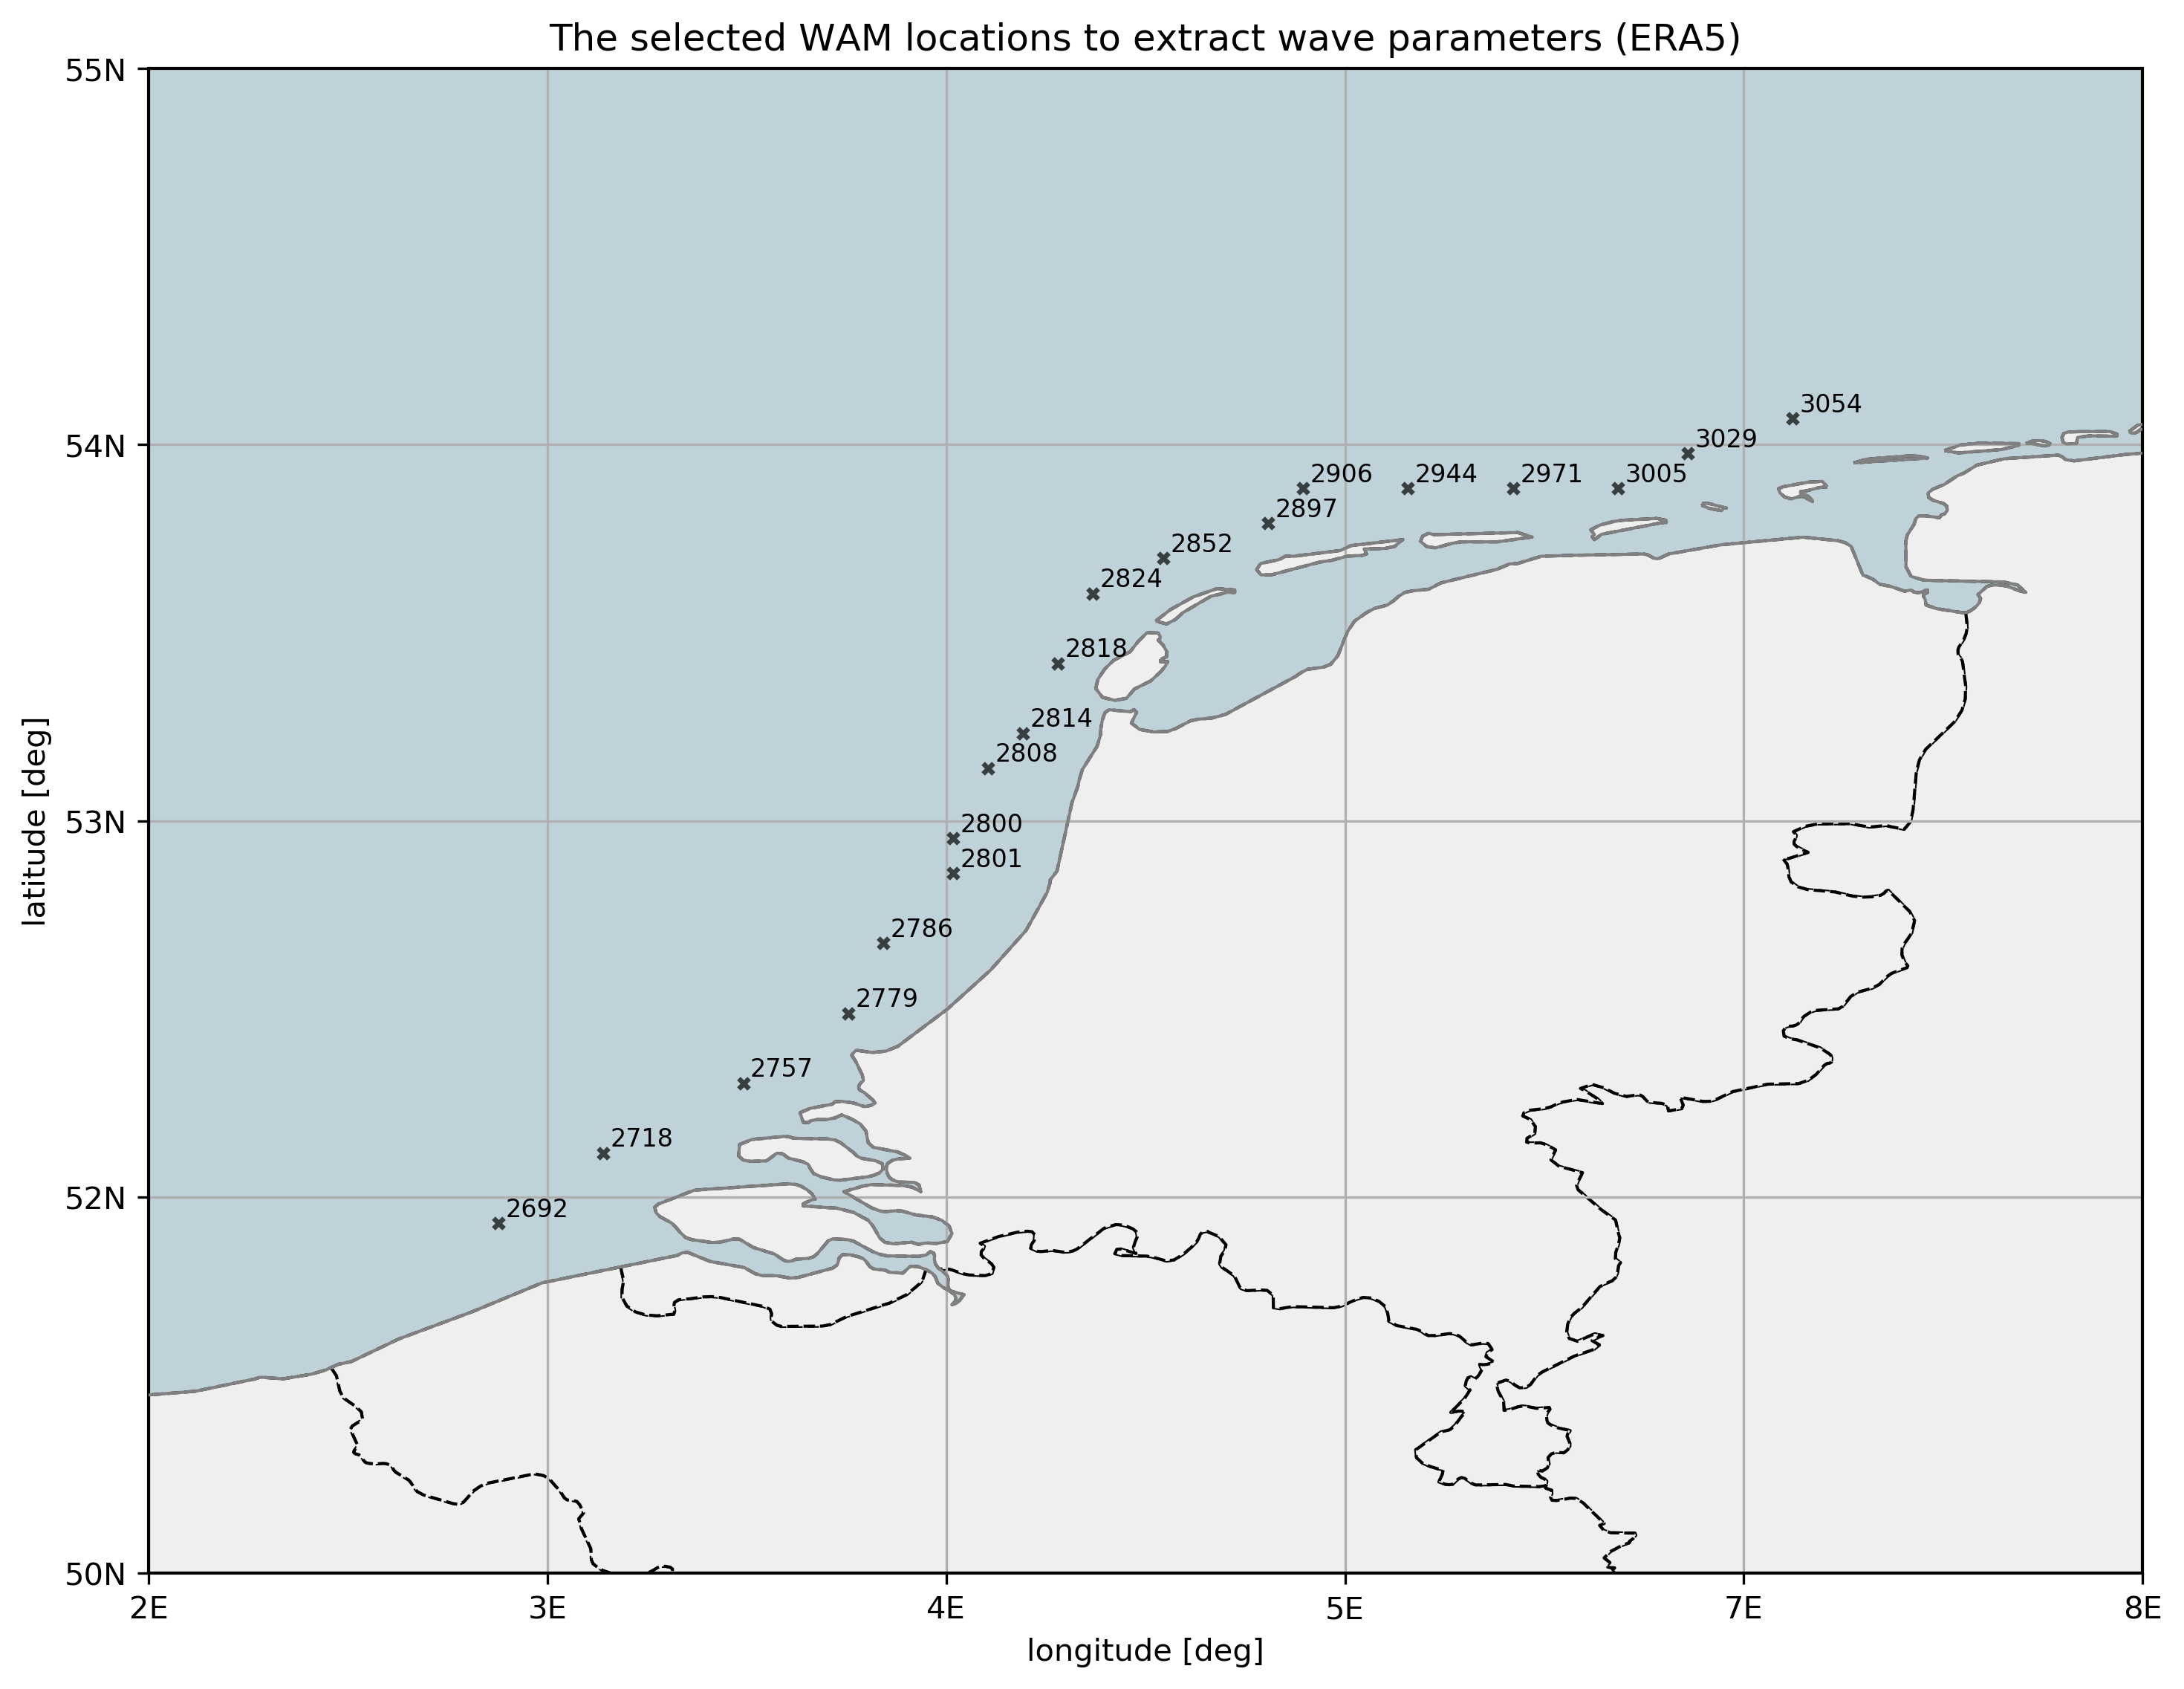

In [9]:
# plot the measurement station locations
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(lonWAM)-1, max(lonWAM)+1)                 
_ = ax.set_ylim(min(latWAM)-1, max(latWAM)+1) 
_ = ax.set_xticks(np.linspace(min(lonWAM)-1, max(lonWAM)+1, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(latWAM)-1, max(latWAM)+1, num=5), crs=cartopy.crs.PlateCarree()) 

# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# create accurate plot using 10m data, note that this is unnecessary on global scale
text_font = {'size':'8'}
for i, j, k in zip(lonWAM, latWAM, station):
    ax.scatter(i, j, c='k', lw=0, marker='X', s=20, alpha=0.7, zorder=10)
    ax.text(i+0.02, j+0.02, "%s"%k, zorder=11, **text_font)
ax.set_title('The selected WAM locations to extract wave parameters (ERA5)')
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

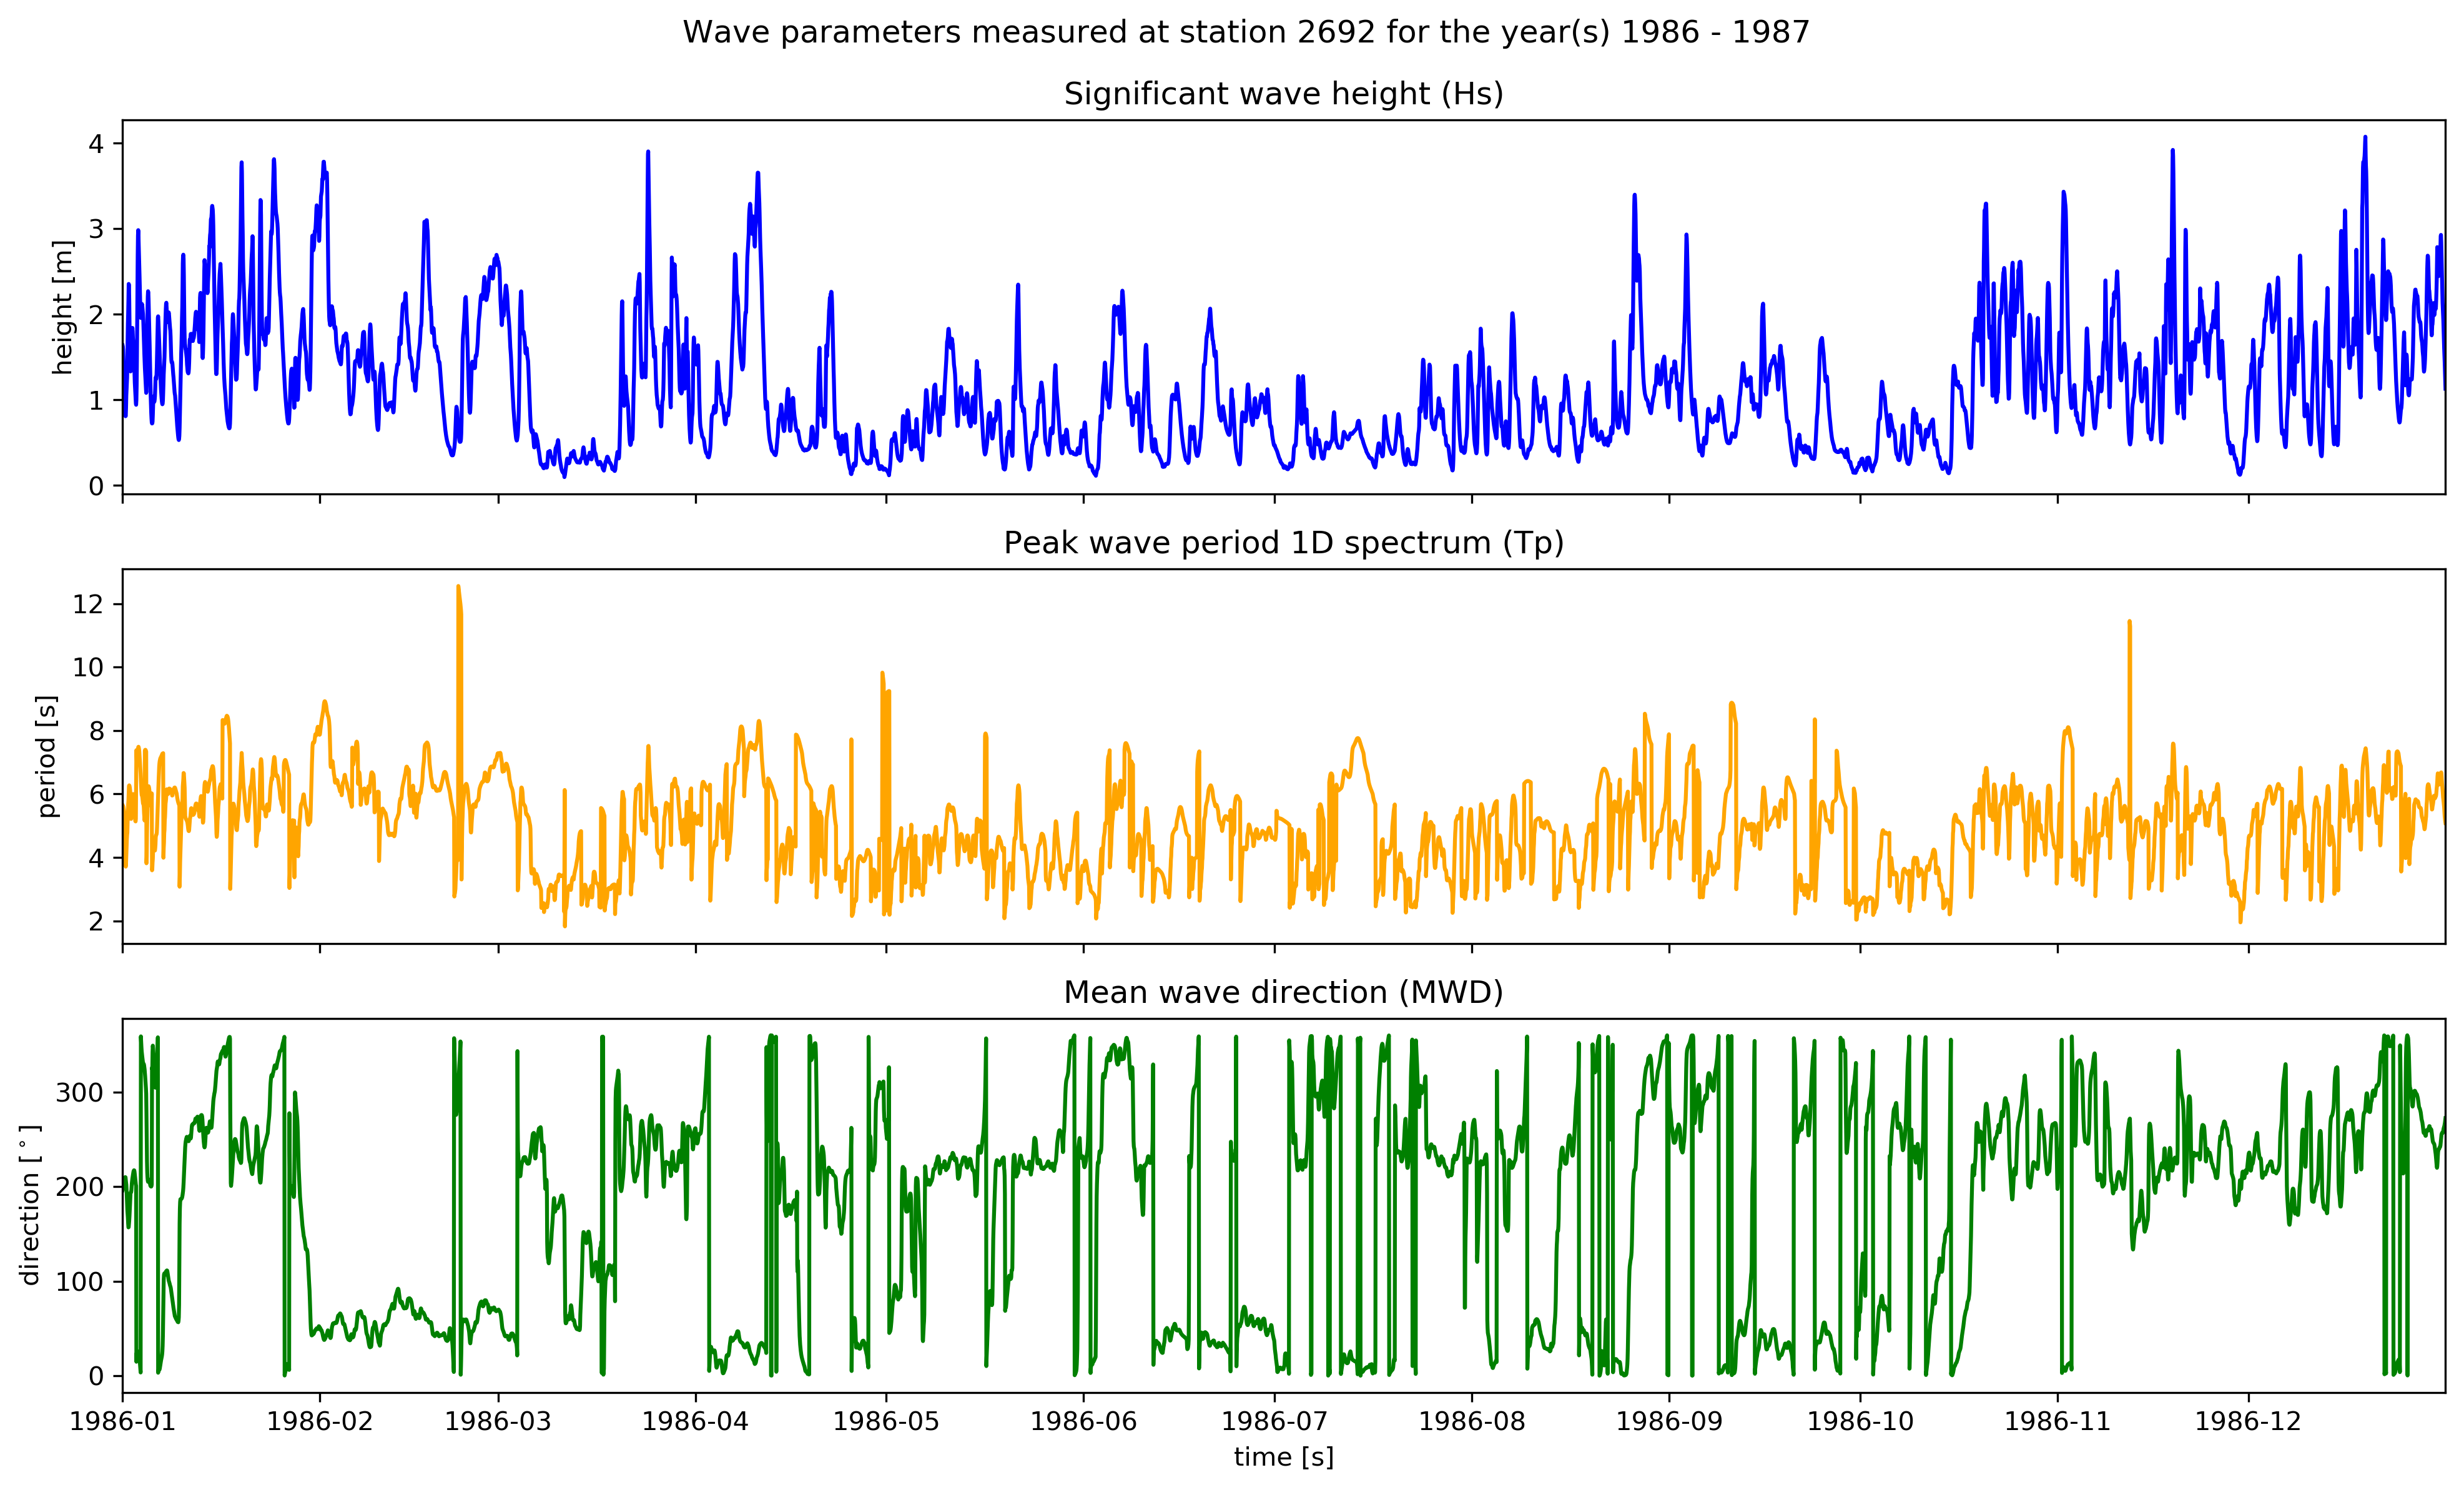

In [114]:
# verification: plot temporal series [TODO: correct the script for the locations... not its not working well]
sel_stat = 0 # 0-8 determine the location to visualize 
# 19 stations are reduced to 9 as some are on the land (mapped to closest cell in the sea)
# and others overlap as they are too close originally (due to the grid resolution)

# setup the folder where we want to extract data from (created .netcdf files)
folder2 = r'C:\checkouts\trunk\tests\testing_Etienne\datasets'

# open the data in this script to get the info -> from saved NetCDF file
#DS_WAM_ERA5 = Dataset(os.path.join(folder2,'WAM_ERA5_WAVE.nc'))
#time_WAM_ERA5 = list(DS_WAM_ERA5.variables['time'])
#SWH_WAM_ERA5 = list(np.array(DS_WAM_ERA5.variables['SWH']))
#PP1D_WAM_ERA5 = list(np.array(DS_WAM_ERA5.variables['PP1D']))
#MWD_WAM_ERA5 = list(np.array(DS_WAM_ERA5.variables['MWD']))

# direcly from the extracted data
time_WAM_ERA5 = list(Extract_Data_ERA5WAMWAVE.data_dict['time'])
SWH_WAM_ERA5 = []
for j in range(len(Extract_Data_ERA5WAMWAVE.data_dict['variables']['swh'][0])):
    substep = []
    for i in Extract_Data_ERA5WAMWAVE.data_dict['variables']['swh']:
        substep.append(i[j])
    SWH_WAM_ERA5.append(np.array(substep))
PP1D_WAM_ERA5 = []
for j in range(len(Extract_Data_ERA5WAMWAVE.data_dict['variables']['pp1d'][0])):
    substep = []
    for i in Extract_Data_ERA5WAMWAVE.data_dict['variables']['pp1d']:
        substep.append(i[j])
    PP1D_WAM_ERA5.append(np.array(substep))
MWD_WAM_ERA5 = []
for j in range(len(Extract_Data_ERA5WAMWAVE.data_dict['variables']['mwd'][0])):
    substep = []
    for i in Extract_Data_ERA5WAMWAVE.data_dict['variables']['mwd']:
        substep.append(i[j])
    MWD_WAM_ERA5.append(np.array(substep))

# rewrite lists to locations
swh_era5 = [[] for i in range(len(station))]
pp1d_era5 = [[] for i in range(len(station))]
mwd_era5 = [[] for i in range(len(station))]
for idx, (i,j,k) in enumerate(zip(SWH_WAM_ERA5, PP1D_WAM_ERA5, MWD_WAM_ERA5)):
    for idv, (l,m,n) in enumerate(zip(i,j,k)):
        swh_era5[idv].append(l)
        pp1d_era5[idv].append(m)
        mwd_era5[idv].append(n)

# time computations
by = timeWAMy[0]
#ly = int(by+round((time_WAM_ERA5[-1]-time_WAM_ERA5[0])/60/60/24/365.2422,2)) # length of the dataset computed timespan in years
ly = int(by+np.ceil(((time_WAM_ERA5[-1]-time_WAM_ERA5[0]).days)/365))

# make a loop per location
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')
fig.suptitle('Wave parameters measured at station %s for the year(s) %s - %s'%(station[sel_stat], by, ly), y=.94)
    
plt.subplot(3,1,1)
plt.title('Significant wave height (Hs)')
plt.plot(time_WAM_ERA5, swh_era5[sel_stat], 'b-')
plt.ylabel('height [m]')
plt.xlim(time_WAM_ERA5[0], time_WAM_ERA5[-1])
ax1 = plt.gca()
ax1.set_xticklabels([])
    
plt.subplot(3,1,2)
plt.title('Peak wave period 1D spectrum (Tp)')
plt.plot(time_WAM_ERA5, pp1d_era5[sel_stat], '-', color='orange')
plt.ylabel('period [s]')
plt.xlim(time_WAM_ERA5[0], time_WAM_ERA5[-1])
ax2 = plt.gca()
ax2.set_xticklabels([])
    
plt.subplot(3,1,3)
plt.title('Mean wave direction (MWD)')
plt.plot(time_WAM_ERA5, mwd_era5[sel_stat], 'g-')
plt.ylabel('direction [$^\circ$]')
#plt.xlabel('julian time (seconds from 1970-01-01 00:00:00) [s]')
plt.xlabel('time [s]')
plt.xlim(time_WAM_ERA5[0], time_WAM_ERA5[-1])
ax3 = plt.gca()

Task 1b. Extract wave parameters for year 1986 in a gridded box

In [2]:
# select a spatial range (box) for which data is to be extracted -> NEEDS TO BE A SQUARE BOX 
#steplon = 2 # degrees
#lonl = -5 # left lon value
#lonr = 5 # right lon value
#steplat = 2 # degrees
#latl = 50 # lower lat value
#latu = 60 # upper lat value
#xrange = np.arange(lonl, lonr+steplon, steplon).tolist() 
#yrange = np.arange(latl, latu+steplat, steplat).tolist() 
#
#coordsBOXWAVE = {'LON': xrange, 'LAT': yrange}
#    
## use the SDToolBox function to create input data
#Input_DataBOXWAVE= ind.InputData(
#    input_coordinates=coordsBOXWAVE, 
#    input_variables=['swh'], 
#    input_scenarios=['era5'],
#    input_years=timeWAMy, 
#    is_gridded = True)
#
## use the SDToolBox function to extract data
#print(Input_DataBOXWAVE.input_variables)
#Extract_Data_ERA5BOXWAVE = exd.ExtractData.get_era_5(dir_ERA5, Input_DataBOXWAVE)

# generate output data for waves
#ERA5BOX = oud.OutputData.generate_netcdf(
#    Extract_Data_ERA5BOX,
#    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
#    base_name='BOX',
#    dataset_code='ERA5_WAVE')

steplon = 1
lonl = -5
lonr = 5
steplat = 1
latl = 50
latu = 60
xrang = np.arange(lonl, lonr+steplon, steplon).tolist()
yrang = np.arange(latl, latu+steplat, steplat).tolist()

coordsBOX = {'LON': xrang, 'LAT': yrang}
timeWAMy = [1981] # 1987 to 2018
variables = ['swh']

# use the SDToolBox function to create input data
Input_DataBOXWAVE= ind.InputData(
    input_coordinates=coordsBOX, 
    input_variables=['swh'], 
    input_scenarios=['era5'],
    input_years=timeWAMy, 
    is_gridded = True)

# use the SDToolBox function to extract data
print(Input_DataBOXWAVE.input_variables)
Extract_Data_ERA5BOXWAVE = exd.ExtractData.get_era_5(r'P:\metocean-data\open\ERA5\data\Global', Input_DataBOXWAVE)

['swh']
Extracting variable: Hs, year 1981.


In [3]:
print(Input_DataBOXWAVE.input_coordinates)
print(Extract_Data_ERA5BOXWAVE.data_dict)

{'LON': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], 'LAT': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]}
{'lat': [81, 72, 80, 80, 70, 70, 68, 66, 64, 60, 62], 'lon': [349, 351, 352, 353, 358, 359, 361, 363, 365, 367, 367], 'time': [datetime.datetime(1981, 1, 1, 0, 0), datetime.datetime(1981, 1, 1, 1, 0), datetime.datetime(1981, 1, 1, 2, 0), datetime.datetime(1981, 1, 1, 3, 0), datetime.datetime(1981, 1, 1, 4, 0), datetime.datetime(1981, 1, 1, 5, 0), datetime.datetime(1981, 1, 1, 6, 0), datetime.datetime(1981, 1, 1, 7, 0), datetime.datetime(1981, 1, 1, 8, 0), datetime.datetime(1981, 1, 1, 9, 0), datetime.datetime(1981, 1, 1, 10, 0), datetime.datetime(1981, 1, 1, 11, 0), datetime.datetime(1981, 1, 1, 12, 0), datetime.datetime(1981, 1, 1, 13, 0), datetime.datetime(1981, 1, 1, 14, 0), datetime.datetime(1981, 1, 1, 15, 0), datetime.datetime(1981, 1, 1, 16, 0), datetime.datetime(1981, 1, 1, 17, 0), datetime.datetime(1981, 1, 1, 18, 0), datetime.datetime(1981, 1, 1, 19, 0), datetime.datetime(1981

swh
mwd
pp1d
[]


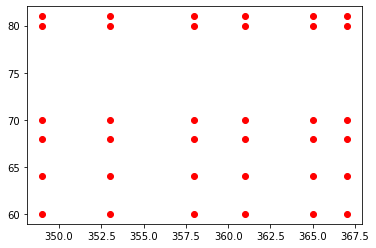

In [160]:
# verification: plot with spatial maps of the mean values and standard deviation
#print(Extract_Data_ERA5BOXWAVE.data_dict)
grd_lon = []
grd_lat = []
for i in Extract_Data_ERA5BOXWAVE.data_dict['lon']:
    grd_lon.append(i)
for i in Extract_Data_ERA5BOXWAVE.data_dict['lat']:
    grd_lat.append(i)
x,y = np.meshgrid(grd_lon, grd_lat)
plt.plot(x, y, 'ro')

for i in Extract_Data_ERA5BOXWAVE.data_dict['variables']:
    print(i)

print(Extract_Data_ERA5BOXWAVE.data_dict['variables']['mwd'])

Task 2. Extract mean sea level pressure from ERA5 dataset on a gridded box on the North Sea

In [15]:
# select a spatial range (box) for which data is to be extracted
steplon = 1 # degrees
lonl = 3 # left lon value
lonr = 4 # right lon value
steplat = 1
latl = 53 # lower lat value
latu = 54 # upper lat value
xrange = np.arange(lonl, lonr+steplon, steplon).tolist() 
yrange = np.arange(latl, latu+steplat, steplat).tolist() 

coordsBOXMSL = {'LON': xrange, 'LAT': yrange}
    
# use the SDToolBox function to create input data
Input_DataBOXMSL = ind.InputData(
    input_coordinates=coordsBOXMSL, 
    input_variables=['msl'], 
    input_scenarios=['era5'],
    input_years=timeWAMy, 
    is_gridded = True)

# use the SDToolBox function to extract data
print(Input_DataBOXMSL.input_variables)
Extract_Data_ERA5BOXMSL = exd.ExtractData.get_era_5(dir_ERA5, Input_DataBOXMSL)

['msl']
Extracting variable: msl_p, year 1986.


In [ ]:
# verification: plot temporal series of a point in the grid

In [ ]:
# verficiation: plot spatial map of the mean sea level pressure

Task 3. Test functionality to generate output netcdf files for waves and sealevel pressure

In [17]:
# generate output data for waves -> array (task 1a)
ERA5WAMWAVE = oud.OutputData.generate_netcdf(
    Extract_Data_ERA5WAMWAVE,
    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
    base_name='WAM',
    dataset_code='ERA5_WAVE')

# generate output data for waves -> gridded (task 1b) FAILS
ERA5BOXWAVE = oud.OutputData.generate_netcdf(
    Extract_Data_ERA5BOXWAVE,
    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
    base_name='BOX',
    dataset_code='ERA5_WAVE')

# generate output data for sealevel pressure -> gridded (task 2) FAILS
ERA5BOXMSL = oud.OutputData.generate_netcdf(
    Extract_Data_ERA5BOXMSL,
    dir_path=r'C:\checkouts\trunk\tests\testing_Etienne\datasets',
    base_name='BOX',
    dataset_code='ERA5_MSL')

Writing C:\checkouts\trunk\tests\testing_Etienne\datasets\WAM_ERA5_WAVE.nc
writing variable mwd
writing variable swh
writing variable pp1d
Writing C:\checkouts\trunk\tests\testing_Etienne\datasets\BOX_ERA5_WAVE.nc
writing variable mwd


ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
# continue with chunked data, using test_chunkData.py

# 2. Data Preprocessing

Make use of the following functions:
5. predictor_definition (pde)

Task 4. Compute the squared spatial gradients of mean sea level pressure

In [8]:
# dummy netCDF chunk
lat = [43.125, 50, 60.125, 13.5]
lon = [43.125, 50, 60.125, 13.5]
times = pd.date_range('2000-01-01', periods=1000)
coordinates = ['lon', 'lat']
data = np.random.rand(len(times), len(lon), len(lat))
data_array1 = xr.DataArray(
    data,
    coords=[times, lon, lat],
    dims=['time', 'lon', 'lat'])

# real netCDF chunk
HS_chunk = Dataset(os.path.join(r'C:\checkouts\trunk\tests\testing_Etienne\ERA5_data','chunk_era5_Global_Hs_1986.nc'))
data_array2 = xr.DataArray(
    HS_chunk['swh'][0:10,:,:],
    coords=[HS_chunk['time'][0:10], HS_chunk['longitude'][:], HS_chunk['latitude'][:]],
    dims=['time', 'lon', 'lat'])

In [9]:
# spatial gradient computation -> may take a while
spatgrad_resultWAVE = pde.PredictorDefinition.compute_spatial_gradients(data_array = data_array2)

[0.04468479199816283, 0.037357616328655106, 0.03178222225966059, 0.027907956547258597, 0.025620354179348492, 0.026068734430703608, 0.026865886319669734, 0.0281849930042335, nan, 0.047256646787964075]


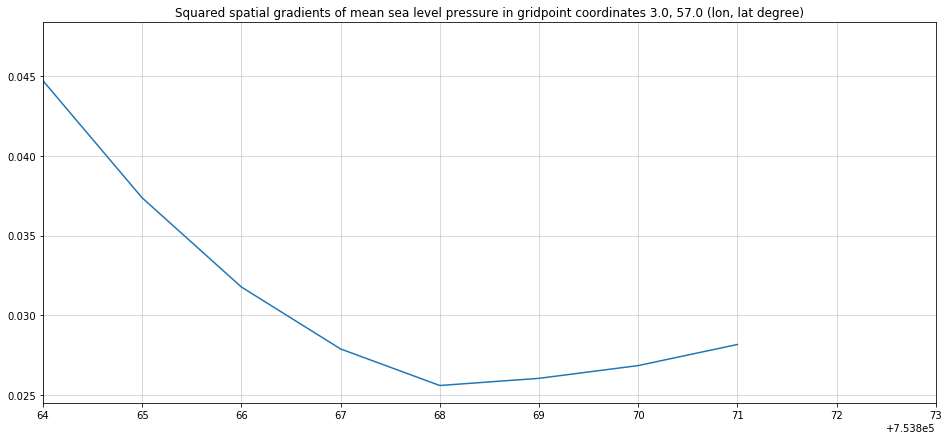

In [47]:
# verification: for a point in the grid plot temporal series

select_gridx = 0 # the x grid point
select_gridy = 0 # the y grid point
temp_csg = []
for i in spatgrad_resultWAVE:
    temp_csg.append(i[select_gridx][select_gridy])
    
print(temp_csg)
    
plt.figure(figsize=(16,7))
plt.plot(HS_chunk['time'][0:10].tolist(), temp_csg)
plt.grid(alpha=0.6)
plt.xlim(HS_chunk['time'][0:10].tolist()[0], HS_chunk['time'][0:10].tolist()[-1])
plt.title('Squared spatial gradients of mean sea level pressure in gridpoint coordinates %s, %s (lon, lat degree)'%(HS_chunk['longitude'][:][select_gridx], HS_chunk['latitude'][:][select_gridy]));

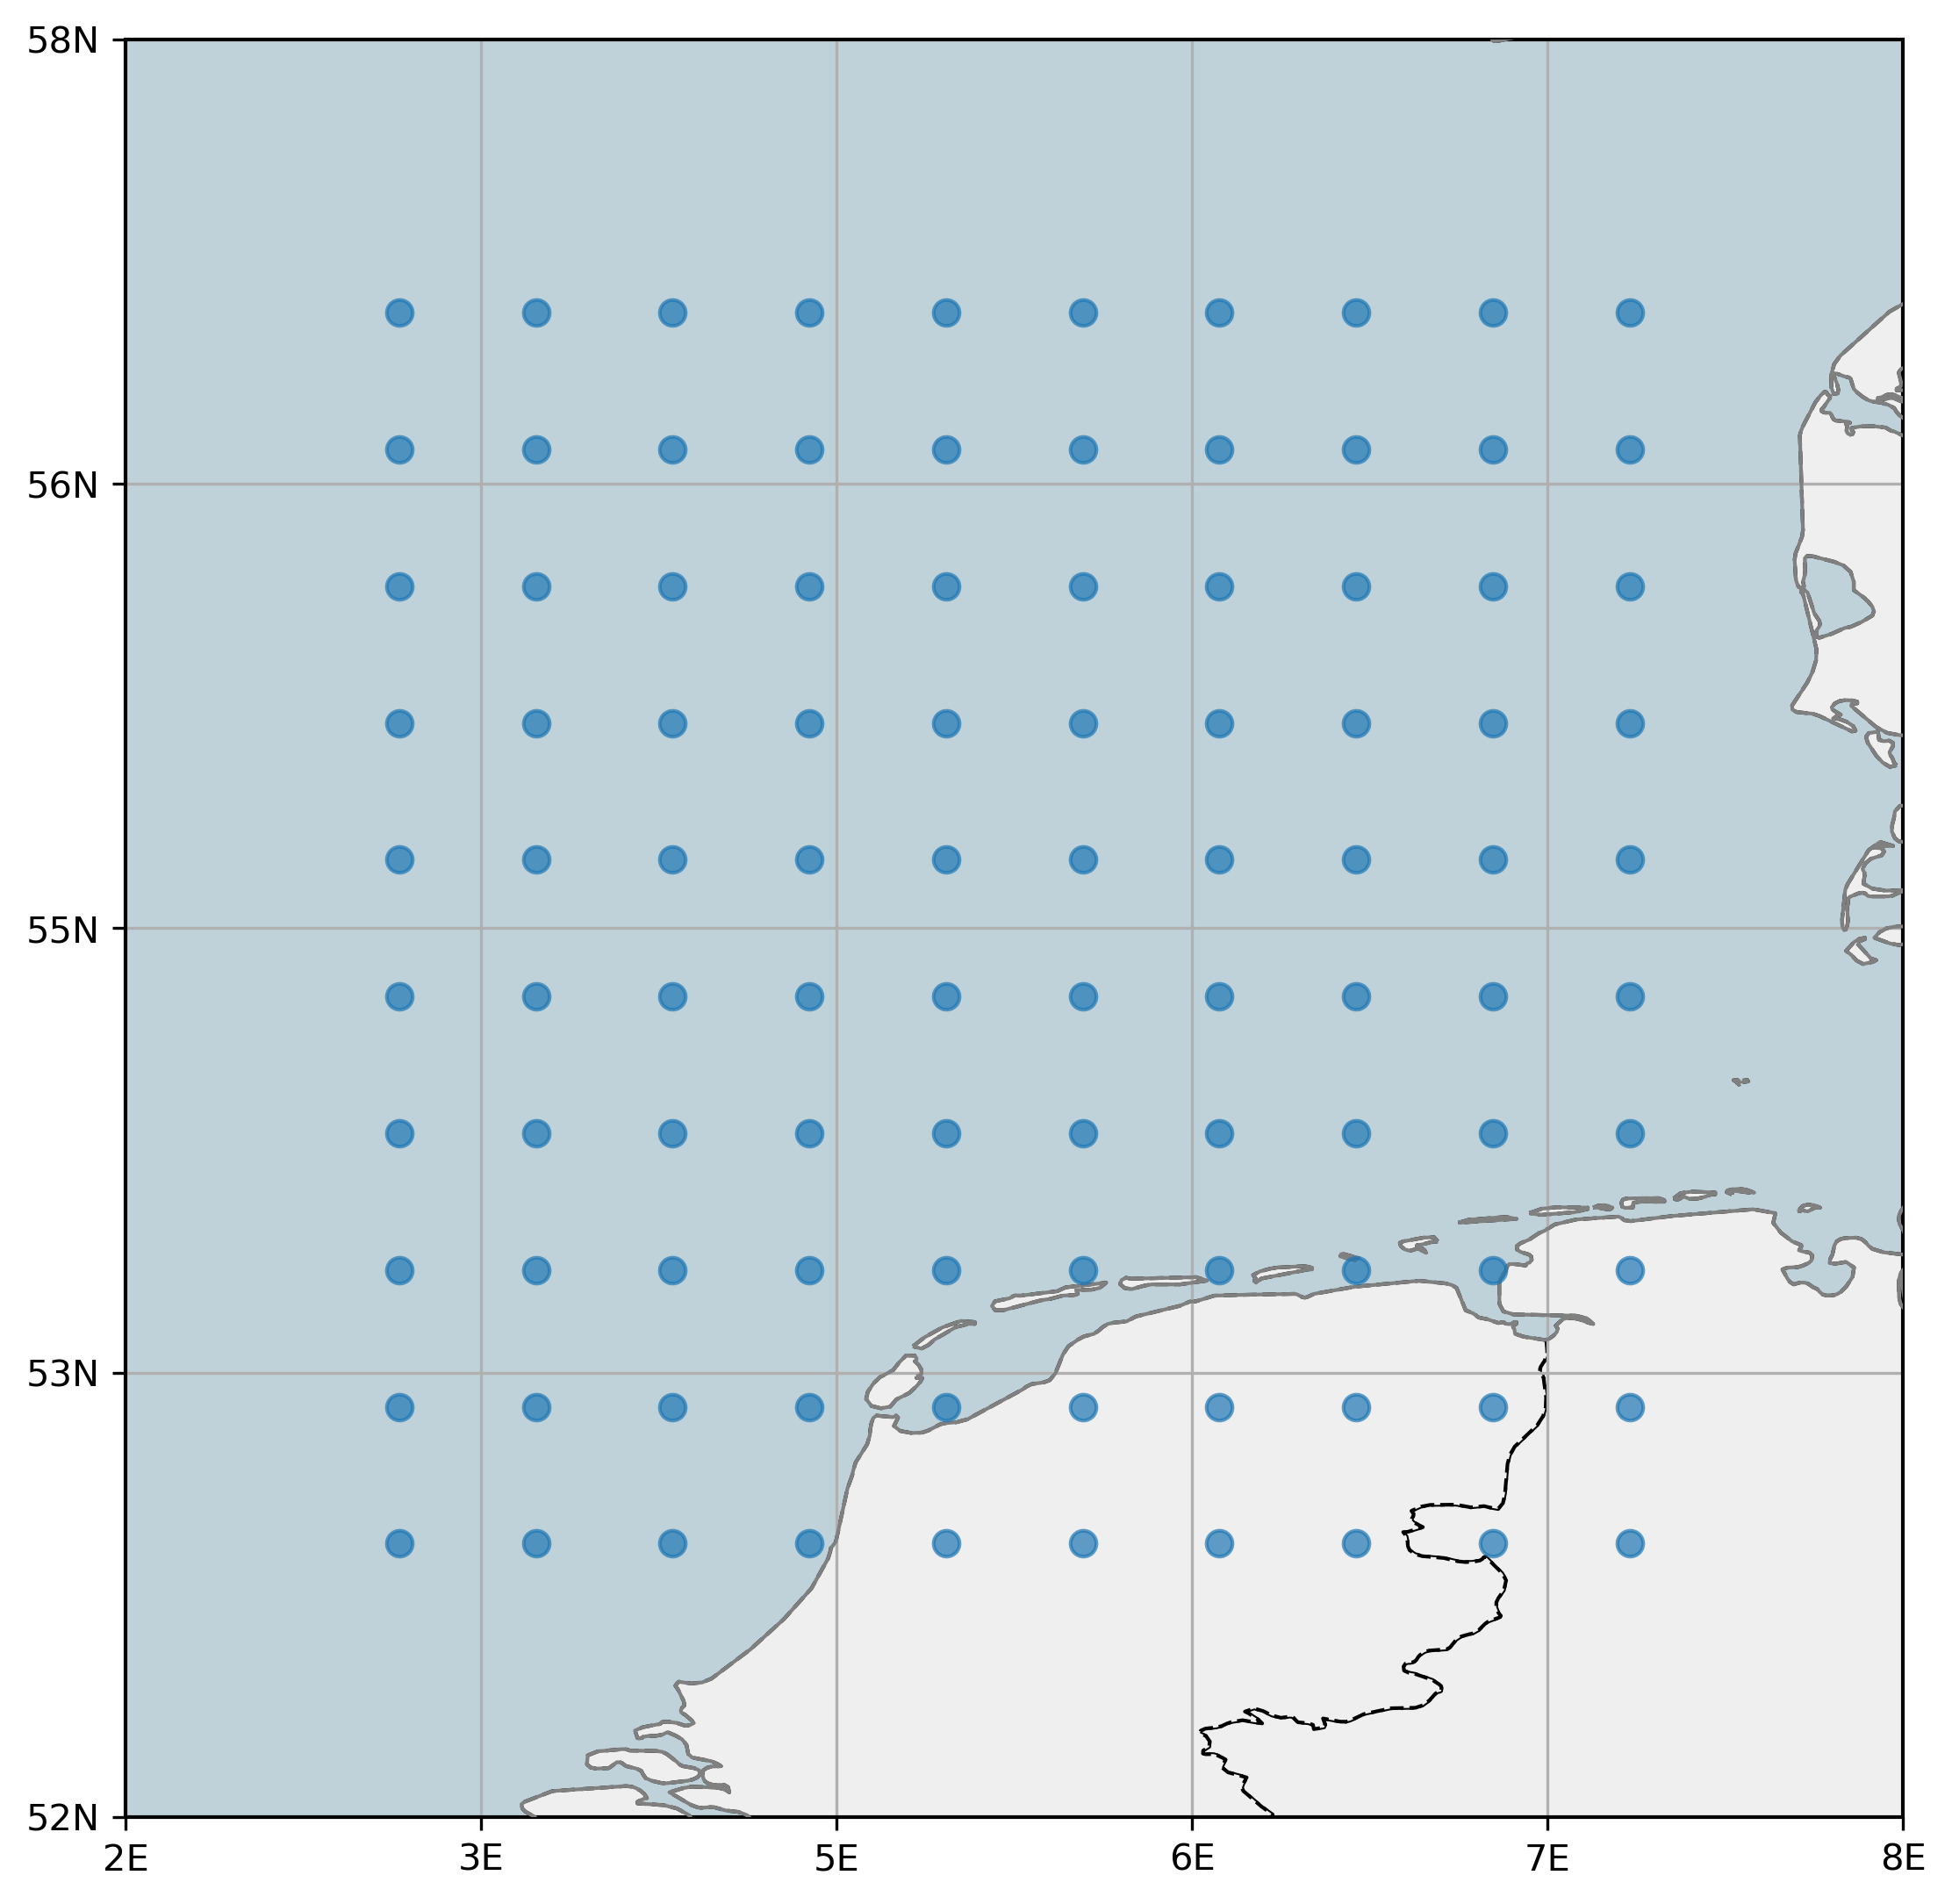

In [59]:
# verification: spatial map of the spatial gradient of mean sea level pressure
fig = plt.figure(figsize=(16, 9), dpi=300, facecolor='white')

# world map
ax = plt.axes([0, 0.12, 0.83, 0.75],projection=cartopy.crs.PlateCarree())
ax.grid()

_ = ax.set_xlim(min(HS_chunk['longitude'][:])-1, max(HS_chunk['longitude'][:])+1)                 
_ = ax.set_ylim(min(HS_chunk['latitude'][:])-1, max(HS_chunk['latitude'][:])+1) 
_ = ax.set_xticks(np.linspace(min(HS_chunk['longitude'][:])-1, max(HS_chunk['longitude'][:])+1, num=6), crs=cartopy.crs.PlateCarree()) 
_ = ax.set_yticks(np.linspace(min(HS_chunk['latitude'])-1, max(HS_chunk['latitude'])+1, num=5), crs=cartopy.crs.PlateCarree()) 

# Set RGB value to ocean colour '#bfd2d9' has 191, G:210, B:217 as 10m ocean cartopy import gives errors
ax.imshow(np.tile(np.array([[[191, 210, 217]]], dtype=np.uint8), [2, 2, 1]), origin='upper', transform=cartopy.crs.PlateCarree(), extent=[-180, 180, -180, 180])

# load features, add features and add axes
country_10m = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')
ax.add_feature(country_10m, edgecolor='k', linestyle='--', facecolor='#EEEFEE')
ax.coastlines(resolution='10m', color='grey', zorder=5);

lon_formatter = LongitudeFormatter(number_format='.0f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# plot the data
plotcoordx, plotcoordy = np.meshgrid(HS_chunk['longitude'][:].tolist(), HS_chunk['latitude'][:].tolist())
# insert c, cmap, vmin & vmax 
ax.scatter(plotcoordx.flatten(),plotcoordy.flatten(), zorder=13,alpha=0.7,s=50, transform=cartopy.crs.PlateCarree());#,c=metricsdf.loc[ioceaneu,idx[ii,mom]].values,cmap=cm[ii],vmin=dictlims[ii][0], vmax=dictlims[ii][1])

Task 5. Temporal resampling

In [77]:
# dummy dataset chunk
dataset = xr.Dataset(
    {
        'var_name': (
            ('time', 'lat', 'lon'),
            20 * np.random.rand(1464).reshape(366, 2, 2)),
    },
    coords={
        'time': pd.date_range(
                '01/01/1979',
                periods=366,
                freq=pd.DateOffset(days=1)),
        'lat': [10, 20],
        'lon': [150, 160]})
dataset.attrs['cdm_data_type'] = True

# real dataset chunk (TODO: to be filled in)
dataset = xr.Dataset(
    {
        'var_name': (
            ('time', 'lat', 'lon'),
            HS_chunk['swh'][0:10,:,:]),
    },
    coords={
        'time': HS_chunk['time'][0:10],
        'lat': HS_chunk['latitude'][:],
        'lon': HS_chunk['longitude'][:]})
dataset.attrs['cdm_data_type'] = True

# wave climate data: hourly to 3 hourly
resampled_resultWAVE = dap.DataProcessing.mean_time_resampling(dataset = dataset, 
                                                               scale = 0,
                                                               frequency_string = '3H')

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [116]:
print(pd.date_range('01/01/1979',periods=366,freq=pd.DateOffset(days=1)))
print(HS_chunk['time'][0:10])
print(type(HS_chunk['time'][0]))

print(datetime(1900, 1, 1) + timedelta(hours=int(HS_chunk['time'][0])))
print(datetime(1900, 1, 1) + timedelta(hours=int(HS_chunk['time'][-1])))

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '1979-12-23', '1979-12-24', '1979-12-25', '1979-12-26',
               '1979-12-27', '1979-12-28', '1979-12-29', '1979-12-30',
               '1979-12-31', '1980-01-01'],
              dtype='datetime64[ns]', length=366, freq='<DateOffset: days=1>')
[753864 753865 753866 753867 753868 753869 753870 753871 753872 753873]
<class 'numpy.ma.core.MaskedArray'>
1986-01-01 00:00:00
1986-02-11 15:00:00


In [145]:
# mean sea level pressure and gradient: hourly to 6hourly
resampled_resultMSLP = dap.DataProcessing.mean_time_resampling(dataset = dataset, 
                                                               scale = 0,
                                                               frequency_string = '6H')
resampled_resultGMSLP = dap.DataProcessing.mean_time_resampling(dataset = dataset, 
                                                                scale = 0,
                                                                frequency_string = '6H')

In [ ]:
# verification: for a point in the grid plot temporal series
select_gridx = 0 # the x grid point
select_gridy = 0 # the y grid point
temp_resamWAVE = []
temp_resamMSLP = []
temp_resamGMSLP = []
for i in resampled_resultWAVE:
    temp_resamWAVE.append(i[select_gridx][select_gridy])
for i in resampled_resultWAVE:
    temp_resamWAVE.append(i[select_gridx][select_gridy])
for i in resampled_resultWAVE:
    temp_resamWAVE.append(i[select_gridx][select_gridy])
    
plt.figure(figsize=(16,7))
plt.plot(times.tolist(), temp_csg)
plt.grid(alpha=0.6)
plt.xlim(times.tolist()[0], times.tolist()[-1])
plt.title('Squared spatial gradients of mean sea level pressure in gridpoint coordinates %s, %s (lon, lat degree)'%(lon[select_gridx], lat[select_gridy]));

In [ ]:
# verification: spatial map of the mean sea level pressure and gradient

Task 6. Spatial resampling

In [ ]:
# mean sea level pressure 0.5 degree to 1 degree

In [ ]:
# verification: for a point in the grid plot temporal series

In [ ]:
# verification: spatial map of the mean sea level pressure and gradient

# 3. Predictor Definition

Make use of the following functions:
5. preditor_definition (pde)

Task 7a. Aggregation of atmospheric data correlated with wave generation (averaged during 1 day). For computing daily running means of the 6h spatial fields.

In [ ]:
# predictor_definition library -> atmospheric_averaged_mean

Task 7b. If we are good with time, repeat task 7a with aggregation data option.

In [ ]:
# perform aggregation data option

In [ ]:
# verification: for a point in the grid plot temporal series

In [ ]:
# verification: spatial map of the mean sea level pressure and gradient

Task 8a. Perform Principal Component Analysis on the temporal and spatial fields of mean sea level pressure and the squared gradient. The function returns the Empirical orthogonal functions (EOF) and the principal components (PCs)

In [ ]:
# predictor_definition library -> compute_PCA

In [ ]:
# verification: plot EOFs (spatial map) and PCs (temporal series)

# 4. Statistical Model

Make use of the following functions:
5. preditor_definition (pde)

Task 8b. Compute Principal Component Analysis on the different coastal locations with wave climate (if we are doing well with time). If this task is not done, continue selecting only one wave station in the coast.

In [ ]:
# (statistical model function)?

In [ ]:
# verification: plot EOFs (spatial map) and PCs (temporal series)

Task 9. Normalization of the predictor data (X, they will be the PCs) using Z score method

Task 10. Define calibration and validation subsets with stratified K folds, try with 5 splits (80% calibration; 20% validation) and 2 repetitions to start with.

In [6]:
# verification: Plot temporal series of wave climate selected for calibration and validation.
# (can be using different colors on the same plot).

Task 11. Train the multivariate regression model (Y=alpha0+sum(alphai*Xi)), the predictand Y = Significant wave height, the predictor X= normalized PCs

In [ ]:
# verification: Check which PCs are significative (which numbers are in the model)
# Plot scatter X,Y empirical and X,Y* modelled, for the training subset and the validation subset 
# (you can do this very simply using the average of the coefficients of the 8 models defined, (5-1)splits*2repetitions)

Task 12. Compute accuracy scores for the stratified folds taken for validating

In [ ]:
# (there are functions defined for this in the library statistical model, get_all_scorers())

In [ ]:
# verification: table with scores

Task 13. Repeat 10, 11 and 12 but with wave direction, because the regression model for circular variables is different

In [ ]:
# ..

In [ ]:
# verifications: ...

# 5. Application: Future Wave Projections

In [ ]:
# to be continued